In [1]:
#basics
import numpy as np
import pandas as pd
#viz
import matplotlib.pyplot as plt
import seaborn as sns
#stats
from sklearn import metrics
#env access
import env

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##### Acquire data and parse the log

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [3]:
#get the data
df = pd.read_sql('SELECT * FROM api_access',env.get_db_url('logs'))

In [4]:
#parse it
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13974 non-null  object
 1   timestamp       13974 non-null  object
 2   request_method  13974 non-null  object
 3   request_path    13974 non-null  object
 4   http_version    13974 non-null  object
 5   status_code     13974 non-null  object
 6   size            13974 non-null  int64 
 7   user_agent      13974 non-null  object
dtypes: int64(1), object(7)
memory usage: 873.5+ KB


In [6]:
#first, let's grab some value counts to see where I want to start
for c in df.columns:
    print(f'\n {c} Value Counts:')
    print(df[c].value_counts())


 ip Value Counts:
97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
70.121.214.34         2
52.87.230.102         2
35.175.171.137        2
54.145.52.184         1
3.92.201.136          1
35.174.209.2          1
34.229.70.250         1
54.172.14.223         1
34.207.64.242         1
3.88.129.158          1
52.91.30.150          1
52.90.165.200         1
45.23.250.16          1
Name: ip, dtype: int64

 timestamp Value Counts:
16/Apr/2019 19:56:10    9
16/Apr/2019 19:49:58    8
16/Apr/2019 20:01:30    7
16/Apr/2019 20:12:23    6
16/Apr/2019 20:02:59    6
                       ..
16/Apr/2019 21:10:09    1
16/Apr/2019 21:10:07    1
16/Apr/2019 21:10:05    1
16/Apr/2019 21:10:03    1
17/Apr/2019 12:55:14    1
Name: timestamp, Length: 9953, dtype: int64

 request_method Value Counts:
GET    13974
Name: request_method, dtype: int64

 request_path Value Counts:
/api/v1/sales?page=2                 7

**Notes:**
- Definitely some IP outliers
- timestamp - may want to split this up
  - any date outliers?
  - any time outliers?
- request method and http_version both only have one value
- request_path - parse more
- status codes - 499 outliers
- size - get histogram of that
- user_agent - possibly parse more and classify "jupyter notebook"


In [7]:
#create outlier df
outliers = pd.DataFrame()


In [8]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [9]:
df.timestamp = pd.to_datetime(df.timestamp,format='%d/%b/%Y %H:%M:%S')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ip              13974 non-null  object        
 1   timestamp       13974 non-null  datetime64[ns]
 2   request_method  13974 non-null  object        
 3   request_path    13974 non-null  object        
 4   http_version    13974 non-null  object        
 5   status_code     13974 non-null  object        
 6   size            13974 non-null  int64         
 7   user_agent      13974 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 873.5+ KB


<AxesSubplot:>

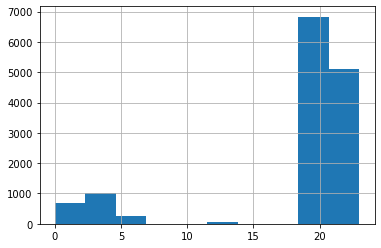

In [11]:
df.timestamp.dt.hour.hist()

**Notes:** most activity b/w 19 and 23 >> likely indicates that this may be in Zulu as opposed to the local time zone

In [12]:
ip_val = pd.DataFrame(df.ip.value_counts())
#create list of ip outliers
ip_out_list = ip_val.index[ip_val.ip < 100]
ip_outliers = df[df.ip.isin(ip_out_list)]
ip_outliers

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
223,3.92.201.136,2019-04-16 19:39:14,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...
224,52.90.165.200,2019-04-16 19:39:15,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
318,3.88.129.158,2019-04-16 19:40:32,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...
320,34.207.64.242,2019-04-16 19:40:33,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
324,54.172.14.223,2019-04-16 19:40:36,GET,/api/v1/,HTTP/1.1,200,162,Slackbot-LinkExpanding 1.0 (+https://api.slack...
325,34.229.70.250,2019-04-16 19:40:37,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
7828,35.175.171.137,2019-04-16 21:22:22,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...
7829,54.145.52.184,2019-04-16 21:22:22,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
7831,52.87.230.102,2019-04-16 21:22:23,GET,/api/v1/sales,HTTP/1.1,200,493905,Slackbot-LinkExpanding 1.0 (+https://api.slack...
8827,35.175.171.137,2019-04-16 21:38:57,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...


In [13]:
hour_out_list = df.timestamp.dt.hour.value_counts()
hour_out_list

20    4587
21    3430
19    2244
22    1684
3      807
1      380
2      284
5      253
4      209
12      70
6       15
0        8
23       2
10       1
Name: timestamp, dtype: int64

**Notes**:  Looking at the breakdown, while hours 0 and 6 and 23 all have relatively few entries, they are on the edges of high activity. Without adding minutes and looking closer, I don't necessarily want to identify those as confirmed outliers.

The relative low occurences in hours 10 and 12 however are worth noting.  I suspect the 19-23 hours are the morning, with the 0-6 being the afternoon.  So the 10 and 12 hours are probably the middle of the night. Marking those as outliers

In [14]:
hour_outliers = df[df.timestamp.dt.hour.isin([10,12])]
hour_outliers

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
13903,45.23.250.16,2019-04-17 10:25:50,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0
13904,97.105.19.58,2019-04-17 12:54:06,GET,/api/v1/sales,HTTP/1.1,200,493905,python-requests/2.21.0
13905,97.105.19.58,2019-04-17 12:54:08,GET,/api/v1/sales?page=2,HTTP/1.1,200,494819,python-requests/2.21.0
13906,97.105.19.58,2019-04-17 12:54:10,GET,/api/v1/sales?page=3,HTTP/1.1,200,499787,python-requests/2.21.0
13907,97.105.19.58,2019-04-17 12:54:11,GET,/api/v1/sales?page=5,HTTP/1.1,200,500461,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13969,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0
13970,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=65,HTTP/1.1,200,511201,python-requests/2.21.0
13971,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0
13972,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0


In [15]:
df.timestamp.sort_values() #only over the course of 24 hours

0       2019-04-16 19:34:42
1       2019-04-16 19:34:42
2       2019-04-16 19:34:44
3       2019-04-16 19:34:46
4       2019-04-16 19:34:48
                ...        
13969   2019-04-17 12:55:12
13970   2019-04-17 12:55:12
13972   2019-04-17 12:55:13
13971   2019-04-17 12:55:13
13973   2019-04-17 12:55:14
Name: timestamp, Length: 13974, dtype: datetime64[ns]

In [16]:
status_outliers = df[df.status_code == '499']
status_outliers

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
1745,97.105.19.58,2019-04-16 19:55:15,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1
1819,97.105.19.58,2019-04-16 19:56:02,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1
4242,97.105.19.58,2019-04-16 20:28:46,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0
4405,97.105.19.58,2019-04-16 20:33:24,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0
4790,97.105.19.58,2019-04-16 20:38:13,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
4862,97.105.19.58,2019-04-16 20:38:55,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
4871,97.105.19.58,2019-04-16 20:39:00,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
5520,97.105.19.58,2019-04-16 20:45:17,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
5539,97.105.19.58,2019-04-16 20:45:28,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0
6860,97.105.19.58,2019-04-16 21:00:35,GET,/api/v1/sales?page=115,HTTP/1.1,499,0,python-requests/2.20.1


In [17]:
path_val = pd.DataFrame(df.request_path.value_counts())
path_out_list = path_val[path_val.request_path < 50].index

In [18]:
path_outliers = df[df.request_path.isin(path_out_list)]
path_outliers

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
116,97.105.19.58,2019-04-16 19:37:26,GET,/api/v1/items?page=99999999999999999998,HTTP/1.1,200,48,python-requests/2.21.0
173,97.105.19.58,2019-04-16 19:38:16,GET,/api/V1/HiZach!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
174,97.105.19.58,2019-04-16 19:38:16,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
204,97.105.19.58,2019-04-16 19:38:58,GET,/api/v1/items/next_page,HTTP/1.1,200,162,python-requests/2.21.0
221,97.105.19.58,2019-04-16 19:39:14,GET,/api/v1/stores?page=666,HTTP/1.1,200,1328,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
12089,72.181.105.81,2019-04-17 01:45:27,GET,/api/v1items,HTTP/1.1,200,162,python-requests/2.21.0
12307,68.201.219.223,2019-04-17 01:58:48,GET,/api/v1/items/api/v1/items?page=2,HTTP/1.1,200,162,python-requests/2.21.0
12308,68.201.219.223,2019-04-17 01:58:48,GET,/api/v1/items/api/v1/items?page=3,HTTP/1.1,200,162,python-requests/2.21.0
12441,52.87.230.102,2019-04-17 02:14:28,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)


In [19]:
df[df.request_path == '/favicon.ico']

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
174,97.105.19.58,2019-04-16 19:38:16,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
224,52.90.165.200,2019-04-16 19:39:15,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
320,34.207.64.242,2019-04-16 19:40:33,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
325,34.229.70.250,2019-04-16 19:40:37,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
566,97.105.19.58,2019-04-16 19:44:04,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
583,97.105.19.58,2019-04-16 19:44:16,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
596,97.105.19.58,2019-04-16 19:44:24,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
602,97.105.19.58,2019-04-16 19:44:28,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
618,97.105.19.58,2019-04-16 19:44:38,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
676,97.105.19.58,2019-04-16 19:45:20,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...


**Notes:** most of these are definitely outliers - primarily caused by incorrect endpoints.  There is favicon.ico - which may be a scrapper, i'll run that against user agent

In [20]:
user_outliers = df[~df.user_agent.str.startswith('python-requests')]

In [21]:
user_outliers.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
173,97.105.19.58,2019-04-16 19:38:16,GET,/api/V1/HiZach!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
174,97.105.19.58,2019-04-16 19:38:16,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
223,3.92.201.136,2019-04-16 19:39:14,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...
224,52.90.165.200,2019-04-16 19:39:15,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
318,3.88.129.158,2019-04-16 19:40:32,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...


In [48]:
df['size'].min()

0

In [49]:
df['size'].max()

513736

(0.0, 10.0)

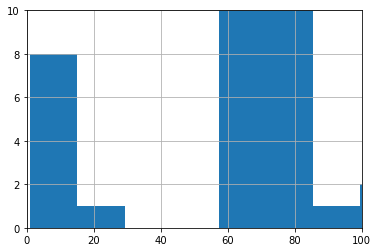

In [22]:
df['size'].value_counts().hist(bins=50)
plt.xlim((0,100))
plt.ylim((0,10))

In [23]:
size_out_list = pd.DataFrame(df['size'].value_counts())
size_out_list

,size
494819,705
3561,548
3659,291
1328,229
1787,219
...,...
327529,1
360297,1
278377,1
343913,1


In [24]:
size_out_list = size_out_list[size_out_list['size']<50].index
size_out_list

Int64Index([0, 130921, 48, 126, 327529, 360297, 278377, 343913, 409449], dtype='int64')

In [25]:
size_outliers = df[df['size'].isin(size_out_list)]
size_outliers

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
116,97.105.19.58,2019-04-16 19:37:26,GET,/api/v1/items?page=99999999999999999998,HTTP/1.1,200,48,python-requests/2.21.0
674,97.105.19.58,2019-04-16 19:45:20,GET,/api/v1/items?page=0,HTTP/1.1,200,48,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
867,97.105.19.58,2019-04-16 19:47:20,GET,/api/v1/sales?page=2,HTTP/1.1,200,278377,python-requests/2.20.1
1435,97.105.19.58,2019-04-16 19:52:25,GET,/api/v1,HTTP/1.1,200,126,python-requests/2.21.0
1745,97.105.19.58,2019-04-16 19:55:15,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1
1819,97.105.19.58,2019-04-16 19:56:02,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1
4242,97.105.19.58,2019-04-16 20:28:46,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0
4405,97.105.19.58,2019-04-16 20:33:24,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0
4790,97.105.19.58,2019-04-16 20:38:13,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
4862,97.105.19.58,2019-04-16 20:38:55,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0


In [26]:
#Now concat all the outliers together, then create a column for is outlier of each class
df_list = [ip_outliers,hour_outliers,status_outliers,path_outliers,user_outliers,size_outliers]

for x in df_list:
    print(x.shape)

(58, 8)
(71, 8)
(16, 8)
(84, 8)
(62, 8)
(28, 8)


In [27]:
#concat along index
outliers = pd.concat(df_list,axis=0)
outliers.shape

(319, 8)

In [28]:
outliers.drop_duplicates(inplace=True)
outliers.shape

(239, 8)

In [40]:
#Now lets add some new columns to visualize overlapping outliers
outliers['is_ip_outlier'] = outliers.index.isin(ip_outliers.index).astype(int)
outliers['is_hour_outlier'] = outliers.index.isin(hour_outliers.index).astype(int)
outliers['is_status_outlier'] = outliers.index.isin(status_outliers.index).astype(int)
outliers['is_path_outlier'] = outliers.index.isin(path_outliers.index).astype(int)
outliers['is_user_outlier'] = outliers.index.isin(user_outliers.index).astype(int)
outliers['is_size_outlier'] = outliers.index.isin(size_outliers.index).astype(int)


In [30]:
outliers.is_ip_outlier.sum()

57

In [31]:
outliers.is_ip_outlier.mean()

0.2384937238493724

In [41]:
col_list = ['is_ip_outlier','is_hour_outlier','is_status_outlier','is_path_outlier','is_user_outlier','is_size_outlier']
outliers['total_outliers']= outliers[col_list].sum(axis=1)

In [42]:
outliers.sort_values(by='total_outliers',ascending=False)

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,is_ip_outlier,is_hour_outlier,is_status_outlier,is_path_outlier,is_user_outlier,is_size_outlier,total_outliers
674,97.105.19.58,2019-04-16 19:45:20,GET,/api/v1/items?page=0,HTTP/1.1,200,48,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0,0,0,1,1,1,3
7829,54.145.52.184,2019-04-16 21:22:22,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),1,0,0,1,1,0,3
224,52.90.165.200,2019-04-16 19:39:15,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),1,0,0,1,1,0,3
11960,70.121.214.34,2019-04-17 01:25:07,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,1,0,0,1,1,0,3
8830,35.174.209.2,2019-04-16 21:38:57,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),1,0,0,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13939,97.105.19.58,2019-04-17 12:54:41,GET,/api/v1/sales?page=39,HTTP/1.1,200,510144,python-requests/2.21.0,0,1,0,0,0,0,1
13940,97.105.19.58,2019-04-17 12:54:43,GET,/api/v1/sales?page=36,HTTP/1.1,200,510850,python-requests/2.21.0,0,1,0,0,0,0,1
13941,97.105.19.58,2019-04-17 12:54:44,GET,/api/v1/sales?page=40,HTTP/1.1,200,511869,python-requests/2.21.0,0,1,0,0,0,0,1
13942,97.105.19.58,2019-04-17 12:54:45,GET,/api/v1/sales?page=38,HTTP/1.1,200,511164,python-requests/2.21.0,0,1,0,0,0,0,1


In [45]:
outliers.iloc[:,-7:].sum()

is_ip_outlier         57
is_hour_outlier       71
is_status_outlier     16
is_path_outlier       84
is_user_outlier       62
is_size_outlier       28
total_outliers       318
dtype: int64

In [46]:
outliers.total_outliers.value_counts()

1    170
2     59
3     10
Name: total_outliers, dtype: int64

In [53]:
outliers[outliers.is_path_outlier == 1].total_outliers.value_counts()

1    39
2    35
3    10
Name: total_outliers, dtype: int64

In [54]:
#This subset is likely students just messing up the code. 
#if it is JUST a path outlier, then it is coming from python requests
outliers[(outliers.is_path_outlier == 1) & (outliers.total_outliers == 1)]

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,is_ip_outlier,is_hour_outlier,is_status_outlier,is_path_outlier,is_user_outlier,is_size_outlier,total_outliers
204,97.105.19.58,2019-04-16 19:38:58,GET,/api/v1/items/next_page,HTTP/1.1,200,162,python-requests/2.21.0,0,0,0,1,0,0,1
221,97.105.19.58,2019-04-16 19:39:14,GET,/api/v1/stores?page=666,HTTP/1.1,200,1328,python-requests/2.21.0,0,0,0,1,0,0,1
375,97.105.19.58,2019-04-16 19:41:12,GET,/api/v1/items/next_page,HTTP/1.1,200,162,python-requests/2.21.0,0,0,0,1,0,0,1
387,97.105.19.58,2019-04-16 19:41:22,GET,/api/v1/items/next_page,HTTP/1.1,200,162,python-requests/2.21.0,0,0,0,1,0,0,1
417,97.105.19.58,2019-04-16 19:41:46,GET,/api/v1//api/v1/items?page=2,HTTP/1.1,200,162,python-requests/2.21.0,0,0,0,1,0,0,1
514,97.105.19.58,2019-04-16 19:43:05,GET,/api/v1/stores?page=0,HTTP/1.1,200,1328,python-requests/2.21.0,0,0,0,1,0,0,1
637,97.105.19.58,2019-04-16 19:44:50,GET,/api/v1//api/v1/items?page=2,HTTP/1.1,200,162,python-requests/2.21.0,0,0,0,1,0,0,1
687,97.105.19.58,2019-04-16 19:45:25,GET,/api/v1//api/v1/items?page=2,HTTP/1.1,200,162,python-requests/2.21.0,0,0,0,1,0,0,1
715,97.105.19.58,2019-04-16 19:45:46,GET,/api/v1//api/v1/items?page=2,HTTP/1.1,200,162,python-requests/2.21.0,0,0,0,1,0,0,1
862,97.105.19.58,2019-04-16 19:47:18,GET,/api/v1//api/v1/items?page=2,HTTP/1.1,200,162,python-requests/2.21.0,0,0,0,1,0,0,1


In [56]:
#These 
outliers[(outliers.is_path_outlier == 1) & (outliers.total_outliers != 1)]

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,is_ip_outlier,is_hour_outlier,is_status_outlier,is_path_outlier,is_user_outlier,is_size_outlier,total_outliers
224,52.90.165.200,2019-04-16 19:39:15,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),1,0,0,1,1,0,3
320,34.207.64.242,2019-04-16 19:40:33,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),1,0,0,1,1,0,3
324,54.172.14.223,2019-04-16 19:40:36,GET,/api/v1/,HTTP/1.1,200,162,Slackbot-LinkExpanding 1.0 (+https://api.slack...,1,0,0,1,1,0,3
325,34.229.70.250,2019-04-16 19:40:37,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),1,0,0,1,1,0,3
7829,54.145.52.184,2019-04-16 21:22:22,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),1,0,0,1,1,0,3
8830,35.174.209.2,2019-04-16 21:38:57,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),1,0,0,1,1,0,3
11960,70.121.214.34,2019-04-17 01:25:07,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,1,0,0,1,1,0,3
12307,68.201.219.223,2019-04-17 01:58:48,GET,/api/v1/items/api/v1/items?page=2,HTTP/1.1,200,162,python-requests/2.21.0,1,0,0,1,0,0,2
12308,68.201.219.223,2019-04-17 01:58:48,GET,/api/v1/items/api/v1/items?page=3,HTTP/1.1,200,162,python-requests/2.21.0,1,0,0,1,0,0,2
12441,52.87.230.102,2019-04-17 02:14:28,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),1,0,0,1,1,0,3


In [ ]:
#the path outliers with favicon.io may be some kind of automatic process (potentially scrappers)
# that is trying to pull a shortcut icon

I should really be looking at bursts of traffic around these times

In [61]:
#ip-specific 68.201.219.223
outliers[outliers.ip =='24.26.242.9'] 


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,is_ip_outlier,is_hour_outlier,is_status_outlier,is_path_outlier,is_user_outlier,is_size_outlier,total_outliers
13882,24.26.242.9,2019-04-17 05:50:21,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,1,0,0,0,0,0,1
13883,24.26.242.9,2019-04-17 05:50:21,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0,1,0,0,0,0,0,1
13884,24.26.242.9,2019-04-17 05:50:22,GET,/api/v1/sales?page=1,HTTP/1.1,200,493905,python-requests/2.21.0,1,0,0,0,0,0,1
13885,24.26.242.9,2019-04-17 05:53:32,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,1,0,0,0,0,0,1
13886,24.26.242.9,2019-04-17 05:53:32,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0,1,0,0,0,0,0,1
13887,24.26.242.9,2019-04-17 05:53:33,GET,/api/v1/sales?page=1,HTTP/1.1,200,493905,python-requests/2.21.0,1,0,0,0,0,0,1
13888,24.26.242.9,2019-04-17 06:11:01,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,1,0,0,0,0,0,1
13889,24.26.242.9,2019-04-17 06:11:01,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0,1,0,0,0,0,0,1
13890,24.26.242.9,2019-04-17 06:11:03,GET,/api/v1/sales?page=1,HTTP/1.1,200,493905,python-requests/2.21.0,1,0,0,0,0,0,1
13891,24.26.242.9,2019-04-17 06:12:20,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,1,0,0,0,0,0,1


In [60]:
#ip-specific 
outliers[outliers.ip =='68.201.219.223'] #normal

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,is_ip_outlier,is_hour_outlier,is_status_outlier,is_path_outlier,is_user_outlier,is_size_outlier,total_outliers
11964,68.201.219.223,2019-04-17 01:29:13,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,1,0,0,0,0,0,1
11965,68.201.219.223,2019-04-17 01:29:15,GET,/documentation,HTTP/1.1,200,348,python-requests/2.21.0,1,0,0,0,0,0,1
11991,68.201.219.223,2019-04-17 01:40:25,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,1,0,0,0,0,0,1
11999,68.201.219.223,2019-04-17 01:40:43,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,1,0,0,0,0,0,1
12305,68.201.219.223,2019-04-17 01:58:47,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,1,0,0,0,0,0,1
12307,68.201.219.223,2019-04-17 01:58:48,GET,/api/v1/items/api/v1/items?page=2,HTTP/1.1,200,162,python-requests/2.21.0,1,0,0,1,0,0,2
12308,68.201.219.223,2019-04-17 01:58:48,GET,/api/v1/items/api/v1/items?page=3,HTTP/1.1,200,162,python-requests/2.21.0,1,0,0,1,0,0,2
12318,68.201.219.223,2019-04-17 01:59:16,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,1,0,0,0,0,0,1
12325,68.201.219.223,2019-04-17 01:59:32,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,1,0,0,0,0,0,1
12331,68.201.219.223,2019-04-17 01:59:51,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,1,0,0,0,0,0,1
